**Text classification using BERT to detect spam email. At the end I have use some actual mail from my spam folder to test the model 😲**

In [ ]:
!pip install tensorflow-text

In [ ]:
!pip install chardet

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import pandas as pd
import numpy as np
import chardet
from sklearn.model_selection import train_test_split

**Data preprocessing**

In [ ]:
with open('/content/drive/MyDrive/Models/spam_or_not/spam.csv', 'rb') as file:
    Encoding  = chardet.detect(file.read())

In [ ]:
Encoding

{'confidence': 0.7257971165545478, 'encoding': 'Windows-1252', 'language': ''}

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Models/spam_or_not/spam.csv", encoding = 'Windows-1252')
df.head(5)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [ ]:
df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'],axis=1,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   object
 1   v2      5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [ ]:
df

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [ ]:
df.rename(columns = {'v1':'category', 'v2':'email'}, inplace = True)

In [ ]:
df

,category,email
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [ ]:
df['label']=df['category'].apply(lambda x: 1 if x=='spam' else 0)
df.sample(5)

,category,email,label
3277,ham,What happened in interview?,0
5070,ham,As in different styles?,0
203,ham,Goodmorning sleeping ga.,0
768,ham,I cant pick the phone right now. Pls send a me...,0
1050,ham,Are you available for soiree on June 3rd?,0


In [ ]:
df.groupby('label').describe()

category                    email         \
         count unique   top  freq count unique   
label                                            
0         4825      1   ham  4825  4825   4516   
1          747      1  spam   747   747    653   

                                                               
                                                     top freq  
label                                                          
0                                 Sorry, I'll call later   30  
1      Please call our customer service representativ...    4

In [ ]:
not_a_spam = df['category'].value_counts()['ham']
spam = df['category'].value_counts()['spam']
print("percentage of spam sample of total dataset is = ", (spam/not_a_spam)*100,"%")


percentage of spam sample of total dataset is =  15.481865284974095 %


In [ ]:
df_spam = df[df['category']=='spam']
df_spam.shape

(747, 3)

In [ ]:
df_not_a_spam = df[df['category']=='ham']
df_not_a_spam.shape

(4825, 3)

In [ ]:
df_not_a_spam_downsampled = df_not_a_spam.sample(df_spam.shape[0])
df_not_a_spam_downsampled.shape

(747, 3)

In [ ]:
df_balanced = pd.concat([df_not_a_spam_downsampled, df_spam])
df_balanced.shape

(1494, 3)

In [ ]:
df_balanced['category'].value_counts()

ham     747
spam    747
Name: category, dtype: int64

In [ ]:
df_balanced.sample(5)

,category,email,label
2125,ham,"Sorry im getting up now, feel really bad- tota...",0
5168,ham,"I‰Û÷ve got some salt, you can rub it in my ope...",0
4377,ham,"Doing nothing, then u not having dinner w us?",0
3989,spam,(Bank of Granite issues Strong-Buy) EXPLOSIVE ...,1
1698,spam,"Free msg. Sorry, a service you ordered from 81...",1


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_balanced['email'],df_balanced['label'], test_size=0.15)

In [ ]:
X_train.head(4)

5391                              Watching ajith film ah?
56      Congrats! 1 year special cinema pass for 2 is ...
1644                            India have to take lead:)
503              Lolnice. I went from a fish to ..water.?
Name: email, dtype: object

**Loading the BERT pre trained model from tensorflow hub**

In [ ]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

**Embedding sentences and check their cosine similarity**

In [ ]:
def get_sentence_embeding(sentences):
    preprocessed = bert_preprocess(sentences)
    return bert_encoder(preprocessed)['pooled_output']

vector = get_sentence_embeding([
    "Mango is sweet fruit",
    "I do not like bananna", 
    "The bmw is a fast car",
    "Audi better than bmw"]
)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity([vector[0]],[vector[1]])

array([[0.89226186]], dtype=float32)

In [ ]:
cosine_similarity([vector[2]],[vector[3]])

array([[0.8765592]], dtype=float32)

In [ ]:
cosine_similarity([vector[0]],[vector[2]])

array([[0.75360006]], dtype=float32)

**Model build and train the model with our data**

In [ ]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)


dropout_layer = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
output_lebel = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(dropout_layer)


model = tf.keras.Model(inputs=[text_input], outputs = [output_lebel])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [ ]:
model.fit(X_train, y_train, epochs=5)

Epoch 1/5
40/40 [==============================] - 395s 10s/step - loss: 0.6360 - accuracy: 0.6509 - precision: 0.6570 - recall: 0.6395
Epoch 2/5
40/40 [==============================] - 387s 10s/step - loss: 0.5018 - accuracy: 0.8172 - precision: 0.7851 - recall: 0.8762
Epoch 3/5
40/40 [==============================] - 387s 10s/step - loss: 0.4239 - accuracy: 0.8676 - precision: 0.8582 - recall: 0.8824
Epoch 4/5
40/40 [==============================] - 388s 10s/step - loss: 0.3816 - accuracy: 0.8660 - precision: 0.8462 - recall: 0.8966
Epoch 5/5
40/40 [==============================] - 389s 10s/step - loss: 0.3509 - accuracy: 0.8747 - precision: 0.8591 - recall: 0.8981


In [ ]:
model.evaluate(X_test, y_test)

8/8 [==============================] - 76s 9s/step - loss: 0.3016 - accuracy: 0.9156 - precision: 0.8879 - recall: 0.9450


[0.3015943169593811,
 0.9155555367469788,
 0.8879310488700867,
 0.9449541568756104]

In [ ]:
y_predicted = model.predict(X_test)

In [ ]:
y_predicted[0:10]

array([[0.1632826 ],
       [0.90434617],
       [0.50187904],
       [0.17129612],
       [0.11950064],
       [0.44625857],
       [0.11067373],
       [0.18665752],
       [0.84542954],
       [0.2523889 ]], dtype=float32)

In [ ]:
y_predicted = y_predicted.flatten()
y_predicted[0:10]

array([0.1632826 , 0.90434617, 0.50187904, 0.17129612, 0.11950064,
       0.44625857, 0.11067373, 0.18665752, 0.84542954, 0.2523889 ],
      dtype=float32)

In [ ]:
y_predicted = np.where(y_predicted > 0.5, 1, 0)
print("Predicted labels \n", y_predicted[0:10])
actual_labels = y_test[0:10].to_numpy()
print("Actual labels \n", actual_labels)

Predicted labels 
 [0 1 1 0 0 0 0 0 1 0]
Actual labels 
 [0 1 1 0 0 0 0 0 1 0]


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

confusion_matrix = confusion_matrix(y_test, y_predicted)
confusion_matrix

array([[103,  13],
       [  6, 103]])

Text(33.0, 0.5, 'Truth')

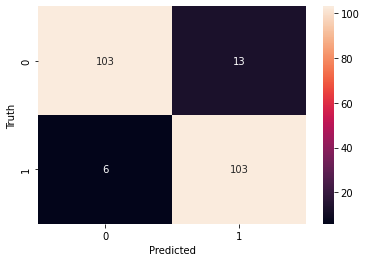

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(confusion_matrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

**These are some actual email text from my email inbox and spam folder. The model predicted the spam and not spam correctly**

In [ ]:
emails = [
    'Open a free account now and Download 37 books in Computer Networks completely free.',
    'It looks like you have not reserved your place yet, but you still have time if you act now. CLAIM YOUR TICKET to The Global Impact Investor Summit 2022.',
    'Do not forget to stock up on your essentials before the weekend! Hurry! The offer is only valid until tonight at 23:59!',
    'Hey Priom, I am busy today. Can we meet tomorrow after lunch?',
    "dear professor, I am very happy to know the result of my last exam."
]
y_predicted = model.predict(emails)
y_predicted = np.where(y_predicted > 0.5, 1, 0)
for x in range(len(y_predicted)):
    labels = ['not a spam', 'spam']
    y = y_predicted[x]
    y = y_predicted.flatten()
    print("The email is a", labels[y[x]])

The email is a spam
The email is a spam
The email is a spam
The email is a not a spam
The email is a not a spam
